<a href="https://colab.research.google.com/github/snymanje/MultiClass-Text-Classification/blob/master/MultiClass_Text_Classification_with_Multiple_Estimators_and_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Objetivo: Avaliar 5 modelos com hyperparamters para o target categoria
---

**1- Descrição do problema ou tarefa:**

Prever a categorias frutas, animais e graos a partir das perguntas.

**2- Descrição da solução de IA:**
Treinamento supervisionado de modelo de classificação as categorias das perguntas (3 classes) com os dados das 16000 perguntas sobre os temas Frutas, animais e graos 

**3- Fonte de dados:**


Livro de perguntas e respostas da Embrapa
https://mais500p500r.sct.embrapa.br/view/index.php4

**4-Variáveis independentes:** 
perguntas

**5- Variável dependente:** 
Categorias frutas, animais e graos


-----------------------------------------------------------------
Autor do caderno: Wellington Rangel
Data: 23/11/2021

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import data and filter only on the needed features an labels
import pandas as pd
import numpy as np

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projeto/dados_agrupados.csv',  sep=',', low_memory=False,encoding='latin-1' )
dataset = dataset[['Pergunta', 'Target_final']]


# Print the top 5 rows
dataset.head()

,Pergunta,Target_final
0,Qual é o centro de origem da pereira?,Frutas
1,Qual é o centro de origem mais importante?,Frutas
2,Como ocorreu a disseminação da pereira pelo mu...,Frutas
3,Quais são as espécies de pereira mais cultivad...,Frutas
4,Quando a pereira foi introduzida no Brasil?,Frutas


In [4]:
dataset["Pergunta"].to_list()[:2]

['Qual é o centro de origem da pereira?',
 'Qual é o centro de origem mais importante?']

#### **Funcao para tratar e limpar os dados**

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopwords = nltk.corpus.stopwords.words('portuguese')


In [8]:
dataset["Pergunta"] = dataset["Pergunta"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [9]:
dataset["Pergunta"] = dataset["Pergunta"].str.lower()

In [10]:
dataset["Pergunta"].to_list()[:5]

['qual centro origem pereira?',
 'qual centro origem importante?',
 'como ocorreu disseminação pereira mundo?',
 'quais espécies pereira cultivadas mundo?',
 'quando pereira introduzida brasil?']

In [11]:
dataset.head()

,Pergunta,Target_final
0,qual centro origem pereira?,Frutas
1,qual centro origem importante?,Frutas
2,como ocorreu disseminação pereira mundo?,Frutas
3,quais espécies pereira cultivadas mundo?,Frutas
4,quando pereira introduzida brasil?,Frutas


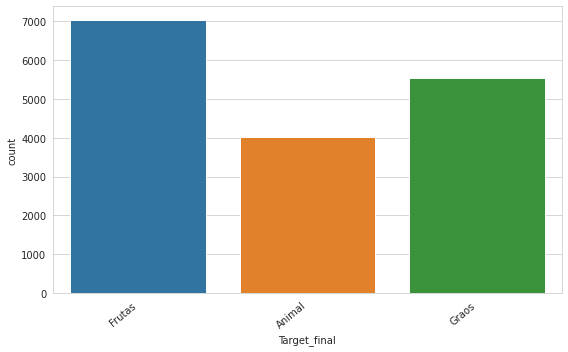

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Target_final', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [13]:
# Shuffel the dataset
dataset = dataset.sample(frac=1)
dataset.head()

,Pergunta,Target_final
14198,em consiste método cultivo meristema?,Frutas
11689,qual duração confinamento cabritos cordeiros?,Animal
1976,como manejados insetos-praga soja orgânica?,Graos
925,que cuidados produtor sementes deve ter adubaç...,Graos
8340,qual consumo diário sal mineral bovino adulto?,Animal


### Dividindo dados de treino e teste

---



In [17]:
# Split into X/y
from sklearn.model_selection import train_test_split, cross_val_score

x = dataset["Pergunta"]
y = dataset["Target_final"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
cv2 = TfidfVectorizer(min_df=1, max_features=50000,ngram_range=(1,2))

X_traincv = cv2.fit_transform(x_train)
x_testcv = cv2.transform(x_test)
print(X_traincv.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### **codigo para avaliar os modelos**

> Bloco com recuo



In [19]:
# Hyperparameter grid RandomizedSearchCV will search over

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ignore ConvergenceWarnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

models = [
    { "estimater": KNeighborsClassifier(),
      "params": {
          "n_neighbors": [25,30,35,45],
          "weights": ['uniform','distance'],
          "leaf_size": [25,30,35]
        }
    },
    { "estimater": DecisionTreeClassifier(),
      "params": {
          "criterion": ['gini','entropy'],
          "splitter": ['best','random'],
          "max_depth": [None,90,95,100],
          "max_features": [None, "auto","sqrt","log2"],
          "random_state": [42]
      }
    },
    { "estimater": MultinomialNB(),
      "params": {
          "fit_prior": [True, False]    
      }
    },
    { "estimater": RandomForestClassifier(),
      "params": {
      "criterion": ['gini','entropy'],
      "bootstrap": [True, False],
      "max_depth": [85,90,95,100],
      "max_features": ['sqrt','log2'],
      "n_estimators": [60, 80, 90],
      "random_state": [42]
      }
    },
    { "estimater": SGDClassifier(),
      "params": {
          "loss": ['hinge','log','perceptron'], 
          "penalty": ['l2', 'l1', 'elasticnet'], 
          "alpha": [0.0001, 0.0003, 0.0010],
          "early_stopping": [True],
          "max_iter": [25000, 50000],
          "eta0": [0.00001],
          "random_state": [42]

          
      }
    }
]

column_names = ["KNeighbors", "DecisionTree", "MultiNB", "RFC", "SGDClassifier"]
entries = []

highest_acc = 0
best_model = None

for model in models:
  print(model["estimater"])

  # Create a based model
  clf = model["estimater"]
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf, param_grid = model["params"], 
                            cv = 3, n_jobs = 1)
  # Fit the model
  grid_search.fit(X_traincv, y_train);

  # Make a prediction on the test split to find model accuracy
  predicted = grid_search.predict(x_testcv)
  acc = accuracy_score(predicted, y_test)
  entries.append(acc)

  print(grid_search.best_params_)

  # If model have the highest accuracy, it's out best model
  if acc > highest_acc:
    highest_acc = acc
    best_model = grid_search

KNeighborsClassifier()
{'leaf_size': 25, 'n_neighbors': 45, 'weights': 'distance'}
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'random_state': 42, 'splitter': 'random'}
MultinomialNB()
{'fit_prior': False}
RandomForestClassifier()
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 80, 'random_state': 42}
SGDClassifier()
{'alpha': 0.0001, 'early_stopping': True, 'eta0': 1e-05, 'loss': 'hinge', 'max_iter': 25000, 'penalty': 'l2', 'random_state': 42}


       Estimater  Accuracy
0     KNeighbors  0.773193
1   DecisionTree  0.825904
2        MultiNB  0.871386
3            RFC  0.807229
4  SGDClassifier  0.886747


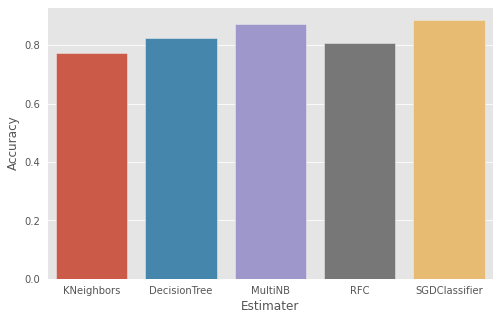

In [20]:
# Plotting each models performance

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 5))

df = pd.DataFrame({"Estimater": column_names, 
                   "Accuracy": entries
                  })

sns.barplot(x='Estimater', y='Accuracy', data=df)

print(df)

In [21]:
# Use best estimater to build a model for predictions
print(best_model.predict(x_testcv))
print(best_model.score(x_testcv, y_test))

['Frutas' 'Frutas' 'Animal' ... 'Animal' 'Frutas' 'Graos']
0.8867469879518072


In [24]:
reg_log = SGDClassifier(eta0=0.00001, loss="log", penalty="elasticnet", max_iter=50000,  alpha=1e-06)
reg_log.fit(X_traincv, y_train)
reg_log.score(x_testcv, y_test)


0.891867469879518

<13276x2063 sparse matrix of type '<class 'numpy.float64'>'
	with 88489 stored elements in Compressed Sparse Row format>

In [ ]:
best_model

GridSearchCV(cv=3, estimator=SVC(), n_jobs=1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
dataset.head(10)

,Pergunta,Target_final
811,quais so medidas controle pragas armaze nagem,Graos
1971,maior desafio tcnico cultivo soja sistema orgnico,Graos
8413,neosporose,Animal
15395,identificar lagartadocartucho campo,Graos
10603,regio brasileira nmero dirio horas sol varia b...,Graos
5736,sistema indicado citros gotejamento microasperso,Frutas
3127,diferena patgenos transportados patgenos trans...,Graos
5060,situao cajueiro planta resistente seca quais s...,Frutas
96,temperatura pode influenciar produo frutos per...,Frutas
3268,funo agente desenvolvimento rural adr formado ...,Graos


### Evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:
best_model

GridSearchCV(cv=3, estimator=SVC(), n_jobs=1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
predicted = best_model.predict(x_testcv)
evaluate_preds(y_test, predicted)

Acc: 90.51%
Precision: 0.91
Recall: 0.91
F1 score: 0.91


{'accuracy': 0.91, 'f1': 0.91, 'precision': 0.91, 'recall': 0.91}

In [ ]:
uniques = dataset.drop('Pergunta', axis=1)
unique_labels = uniques.drop_duplicates()
unique_labels

,Target_final
10802,Graos
4732,Animal
10199,Frutas


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted, 
                                    target_names=dataset['Target_final'].unique()))

              precision    recall  f1-score   support

       Graos       0.94      0.91      0.92       801
      Animal       0.89      0.93      0.91      1388
      Frutas       0.91      0.87      0.89      1131

    accuracy                           0.91      3320
   macro avg       0.91      0.90      0.91      3320
weighted avg       0.91      0.91      0.91      3320



* ***Accuracy*** is a good measure to start with if all classes are balanced (e.g. same amount of samples which are labelled with 0 or 1).
* ***Precision*** and ***recall*** become more important when classes are imbalanced.
If false positive predictions are worse than false negatives, aim for higher precision.
If false negative predictions are worse than false positives, aim for higher recall.
* ***F1-score*** is a combination of precision and recall.

In [ ]:
# Visualize confusion matrix with pd.crosstab()
pd.crosstab(y_test,
            predicted,
            rownames=["Actual Labels"],
            colnames=["Predicted Labels"])

Predicted Labels,Animal,Frutas,Graos
Actual Labels,,,
Animal,726,46,29
Frutas,25,1290,73
Graos,22,120,989


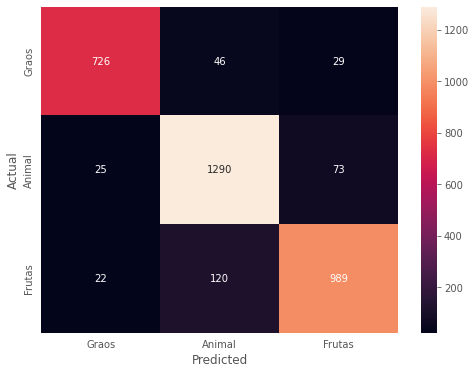

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Target_final.unique(), yticklabels=dataset.Target_final.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
uniques = dataset.drop('Pergunta', axis=1)
unique_labels = uniques.drop_duplicates()
unique_labels

,Target_final
10802,Graos
4732,Animal
10199,Frutas


In [ ]:
inputStr = cv2.transform(["Como planto uva?"])
results = best_model.predict(inputStr )

print(f'Product category id: {results[0]}')
print(f'Product Name: { np.asarray(unique_labels[unique_labels.Target_final.eq(results[0])])[0][0] }')
print(f'Accuracy score: { acc.max() * 100}')

Product category id: Frutas
Product Name: Frutas
Accuracy score: 89.66867469879519
